In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Data Selection & Cleaning

In [2]:
# Select data in NY

import sqlite3
connect = sqlite3.connect('taxi.db')

# Boundaries of NY
lon_bounds = [-74.03, -73.75]
lat_bounds = [40.6, 40.88]

SQL_Query= pd.read_sql_query('''SELECT pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
FROM taxi WHERE (pickup_lon BETWEEN -74.03 AND -73.75) AND (pickup_lat BETWEEN 40.6 AND 40.88) 
AND (dropoff_lon BETWEEN -74.03 AND -73.75 ) AND (dropoff_lat BETWEEN 40.6 AND 40.88)''',connect)

taxi_rides = pd.DataFrame(SQL_Query)
taxi_rides.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration
0,2016-01-30 22:47:32,2016-01-30 23:03:53,-73.988251,40.743542,-74.015251,40.709808,1,3.99,981
1,2016-01-04 04:30:48,2016-01-04 04:36:08,-73.995888,40.760010,-73.975388,40.782200,1,2.03,320
2,2016-01-07 21:52:24,2016-01-07 21:57:23,-73.990440,40.730469,-73.985542,40.738510,1,0.70,299
3,2016-01-01 04:13:41,2016-01-01 04:19:24,-73.944725,40.714539,-73.955421,40.719173,1,0.80,343
4,2016-01-08 18:46:10,2016-01-08 18:54:00,-74.004494,40.706989,-74.010155,40.716751,5,0.97,470


In [3]:
# Clean data
# Positive pax count, positive distance
taxi = taxi_rides[(taxi_rides['passengers']>0) & (taxi_rides['distance']>0)]

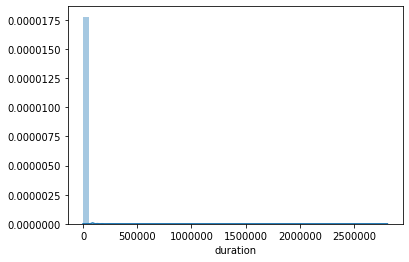

In [4]:
# See distribution of duration
sns.distplot(taxi['duration']);

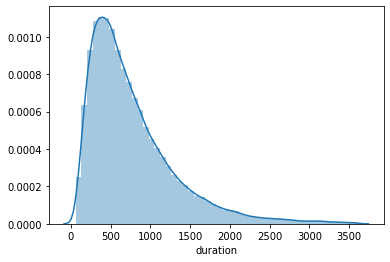

In [5]:
# Remove duration outliers - at least 1 minute, at max 1 hour
taxi = taxi[(taxi['duration']<=60*60)&(taxi['duration']>=60)]
sns.distplot(taxi['duration']);

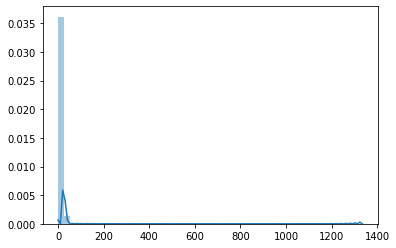

In [6]:
# Check average speed
sns.distplot(taxi['distance']/(taxi['duration']/3600));

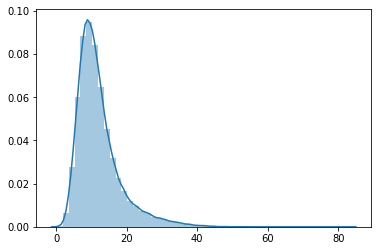

In [7]:
# Remove outliers
taxi = taxi[(taxi['distance']/(taxi['duration']/3600))<=100]
sns.distplot(taxi['distance']/(taxi['duration']/3600));

In [9]:
# Select points that are in Manhattan area
# shape stores latitudes and longitudes of Manhattan
shape = pd.read_csv('manhattan_shape.csv')

In [194]:
# Function that determines whether lat,long is in Manhattan
manhattan_lat = shape['lat']
manhattan_lon = shape['lon']
def manhattan(lat,lon):
    corners = shape.shape[0]
    insideShape = False
    j = corners-1
    i = 0
    while i<corners:
        if ((manhattan_lon[i]<=lon) or (manhattan_lon[j]<=lon)) and (((manhattan_lat[i]<lat) and (manhattan_lat[j]>=lat)) or ((manhattan_lat[j]<lat) and (manhattan_lat[i]>=lat))):
            if manhattan_lon[i]+(lat-manhattan_lat[i])*(manhattan_lon[j]-manhattan_lon[i])/(manhattan_lat[j]-manhattan_lat[i])<lon:
                insideShape = not insideShape
        j = i
        i += 1
    return insideShape

In [196]:
pu=taxi[['pickup_lon','pickup_lat']].apply(lambda x: manhattan(x['pickup_lat'],x['pickup_lon']),axis=1)
do=taxi[['dropoff_lat','dropoff_lon']].apply(lambda x: manhattan(x['dropoff_lat'],x['dropoff_lon']),axis=1)
manhattan_pu = taxi[pu]
manhattan_do = taxi[do]

In [197]:
# Both pickups and dropoffs in Manhattan
manhattan_taxi = taxi[pu & do]

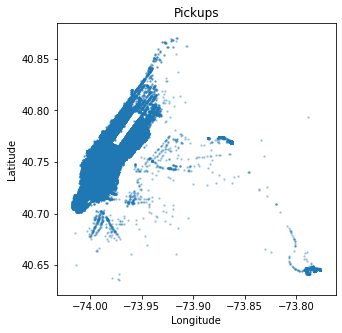

In [200]:
# Take a look at geographical locations of pickups
def geo_viewer(df):
    plt.scatter(df['pickup_lon'], df['pickup_lat'], s=2, alpha = 0.3)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Pickups')

plt.figure(figsize=(5, 5))
geo_viewer(manhattan_taxi)

## Exploratory Data Analysis

In [40]:
# Create datetime column for pickup
manhattan_taxi['pu'] = pd.to_datetime(manhattan_taxi['pickup_datetime'])
manhattan_taxi['date'] = manhattan_taxi['pu'].apply(lambda x:x.date())

C:\Users\nacho\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\nacho\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


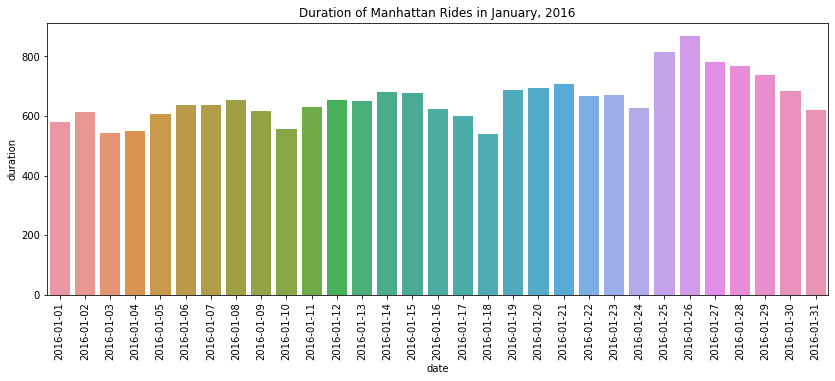

In [59]:
# See average durations across different dates
plt.figure(figsize=(14,5))
grouped = manhattan_taxi.groupby('date').mean()
ax = sns.barplot(x=grouped.index,y=grouped['duration'])
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.title('Duration of Manhattan Rides in January, 2016')
plt.show()

In [60]:
# Take out dates that are likely to have different number of rides than usual
# New year's, blizzard in 2016
from datetime import date
exceptions = [1,2,3,23,24,25]
exception_dates = [date(2016,1,i) for i in exceptions]
taxi_cleaned = manhattan_taxi[~manhattan_taxi['date'].isin(exception_dates)]

## Feature Engineering

In [120]:
# Split train vs. test set
import sklearn.model_selection
train, test = sklearn.model_selection.train_test_split(taxi_cleaned, train_size=0.8, test_size=0.2, random_state=0)

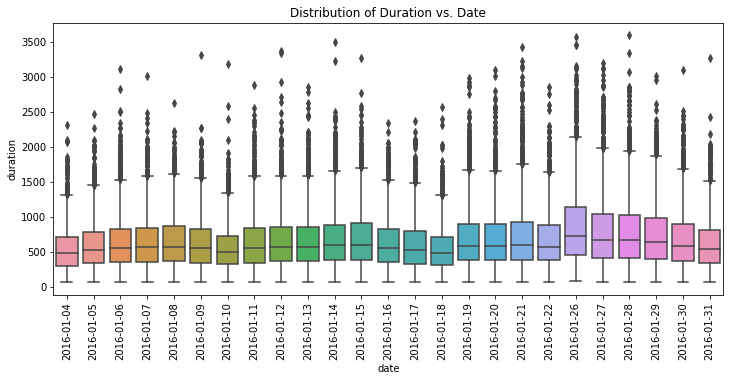

In [121]:
# See distribution of duration
plt.figure(figsize=(12,5))
ax = sns.boxplot(x='date',y='duration',data=train.sort_values('date'))
plt.title('Distribution of Duration vs. Date')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

In [122]:
# Function for adding extra columns
def add_cols(df):
    df_copy = df.copy()
    df_copy.loc[:, 'hour'] = df_copy['pu'].dt.hour
    df_copy.loc[:, 'day'] = df_copy['pu'].dt.weekday
    df_copy.loc[:, 'weekend'] = (df_copy['day'] >= 5).astype(int)
    # Split hour into 3 bins
    df_copy.loc[:, 'period'] = np.digitize(df_copy['hour'], [0, 6, 18])
    df_copy.loc[:, 'speed'] = df_copy['distance'] / df_copy['duration'] * 60 * 60
    return df_copy

In [123]:
train = add_cols(train)
test = add_cols(test)
train.head()

,pickup_datetime,dropoff_datetime,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,passengers,distance,duration,date,pu,hour,day,weekend,period,speed
48097,2016-01-26 21:41:50,2016-01-26 21:46:54,-73.991463,40.750259,-73.999443,40.738991,2,0.90,304,2016-01-26,2016-01-26 21:41:50,21,1,0,3,10.657895
67054,2016-01-06 14:04:49,2016-01-06 14:15:47,-73.985153,40.724312,-73.996109,40.721199,1,0.90,658,2016-01-06,2016-01-06 14:04:49,14,2,0,2,4.924012
74769,2016-01-15 07:27:42,2016-01-15 07:42:20,-73.984848,40.736263,-73.980537,40.763775,1,2.50,878,2016-01-15,2016-01-15 07:27:42,7,4,0,2,10.250569
6659,2016-01-13 19:59:47,2016-01-13 20:04:12,-73.977882,40.751259,-73.980026,40.748573,1,0.50,265,2016-01-13,2016-01-13 19:59:47,19,2,0,3,6.792453
76571,2016-01-14 10:36:45,2016-01-14 10:41:57,-73.981644,40.762459,-73.989738,40.751476,1,0.95,312,2016-01-14,2016-01-14 10:36:45,10,3,0,2,10.961538


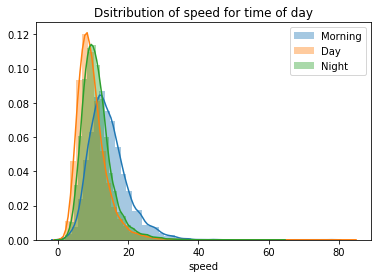

In [124]:
# Distribution of speed vs. time of day
sns.distplot(train[train['period']==1]['speed'],label='Morning')
sns.distplot(train[train['period']==2]['speed'],label='Day')
sns.distplot(train[train['period']==3]['speed'],label='Night')
plt.legend()
plt.title('Dsitribution of speed for time of day');

In [125]:
# Create region variable by using principal components analysis
D = train[['pickup_lon','pickup_lat']].values
pca_n = len(D)
pca_means = np.mean(D, axis=0)
X = (D - pca_means) / np.sqrt(pca_n)
u, s, vt = np.linalg.svd(X, full_matrices=False)

def add_region(df):
    D = df[['pickup_lon','pickup_lat']].values
    X = (D - np.mean(D, axis=0)) / np.sqrt(len(D)) 
    first_pc = X @ vt.T[:,0]
    df.loc[:,'region'] = pd.qcut(first_pc, 3, labels=[0, 1, 2])
    
add_region(train)
add_region(test)

In [133]:
# Create X matrix
from sklearn.preprocessing import StandardScaler

numerical = ['pickup_lon', 'pickup_lat', 'dropoff_lon', 'dropoff_lat', 'distance']
categorical = ['hour', 'day', 'region']

# Standardize numerical values
scaler = StandardScaler()
scaler.fit(train[numerical])

def create_X(df):
    scaled = df[numerical].copy()
    scaled.iloc[:,:] = scaler.transform(scaled) # Convert to standard units
    categoricals = [pd.get_dummies(df[cat], prefix=cat, drop_first=True) for cat in categorical]
    return pd.concat([scaled] + categoricals, axis=1)

X_train = create_X(train)
X_train.head()

,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat,distance,hour_1,hour_2,hour_3,hour_4,hour_5,...,hour_22,hour_23,day_1,day_2,day_3,day_4,day_5,day_6,region_1,region_2
48097,-0.634259,-0.208186,-1.119913,-0.725036,-0.678198,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
67054,-0.242904,-1.425065,-0.926824,-1.470150,-0.678198,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
74769,-0.223975,-0.864571,-0.025003,0.312915,0.443895,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
6659,0.208076,-0.161314,0.004601,-0.323723,-0.958721,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
76571,-0.025222,0.363938,-0.557877,-0.202147,-0.643132,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


## Model Selection

In [134]:
# Baseline - constant model
from sklearn.metrics import mean_squared_error
constant_rmse = np.sqrt(mean_squared_error(test['duration'], [test['duration'].mean()]*len(test)))
constant_rmse

408.74029938088626

In [139]:
# Linear regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
y_train=train['duration']

reg.fit(X_train,y_train)
y_ln_predict=reg.predict(X_test)
linear_rmse = np.sqrt(mean_squared_error(test['duration'],y_ln_predict))
linear_rmse

265.3105280651001

In [147]:
# Linear regression with models fit on different periods
model = LinearRegression()
errors = []

for period in np.unique(train['period']):
    train_sample=train[train['period']==period]
    model.fit(design_matrix(train_sample),train_sample['duration'])
    test_sample = test[test['period']==period]
    y_predict=model.predict(design_matrix(test_sample))
    errors.extend(test_sample['duration']-y_predict)

period_rmse = np.sqrt(np.mean(np.array(errors)**2))
period_rmse

257.61714647505653

In [149]:
# Predict speed then use it to predict duration + distance
reg = LinearRegression()
x_train = design_matrix(train)
y_train = train['speed']
reg.fit(x_train, y_train)
speed_prediction = reg.predict(design_matrix(test))
y_pred_speed = (test['distance']/speed_prediction)*60*60
speed_rmse = np.sqrt(mean_squared_error(test['duration'],y_pred_speed))
speed_rmse

252.13195923850276

In [152]:
choices = ['period', 'region', 'weekend']
temp = list(zip(train.groupby(choices).size().index[0], choices))
temp

[(1, 'period'), (0, 'region'), (0, 'weekend')]

In [155]:
train.groupby(choices).size()

period  region  weekend
1       0       0           1148
                1           1643
        1       0            873
                1            644
        2       0            523
                1            393
2       0       0           7139
                1           2226
        1       0           8514
                1           2179
        2       0          10095
                1           2726
3       0       0           5393
                1           1681
        1       0           5654
                1           1365
        2       0           4311
                1           1182
dtype: int64

In [164]:
for c,v in zip(train.groupby(choices).size().index[0], choices):
    print(c,v)

1 period
0 region
0 weekend


In [166]:
model = LinearRegression()
variables = ['period', 'region', 'weekend']

def duration_error(predictions, observations):
    return predictions - observations['duration']

def speed_error(predictions, observations):
    speed_predictions=predictions/3600
    return duration_error(observations['distance']/speed_predictions,observations)

def tree_regression_errors(outcome='duration', error_fn=duration_error):
    errors = []
    # Loop through all possible combination of variables
    for idx in train.groupby(variables).size().index:
        train_temp, test_temp = train.copy(), test.copy()
        for number, feature in zip(idx, variables):
            train_temp = train_temp[train_temp[feature]==number]
            test_temp = test_temp[test_temp[feature]==number]
        model.fit(design_matrix(train_temp),train_temp[outcome])       
        y_pred=model.predict(design_matrix(test_temp))
        error=error_fn(y_pred,test_temp)
        errors.extend(error)
    return errors

errors = tree_regression_errors()
errors_via_speed = tree_regression_errors('speed', speed_error)
tree_rmse = rmse(np.array(errors))
tree_speed_rmse = rmse(np.array(errors_via_speed))
print('Duration:', tree_rmse, '\nSpeed:', tree_speed_rmse)

Duration: 251.03043521792492 
Speed: 235.8373632701343


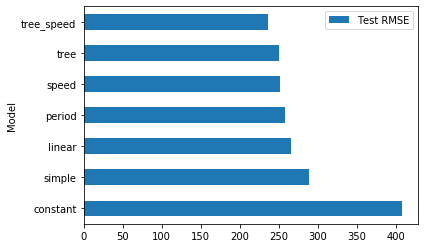

In [167]:
models = ['constant', 'simple', 'linear', 'period', 'speed', 'tree', 'tree_speed']
pd.DataFrame.from_dict({
    'Model': models,
    'Test RMSE': [eval(m + '_rmse') for m in models]
}).set_index('Model').plot(kind='barh');

In [ ]:
# Tree model based on speed predictions performed the best